# SHAP Decision Plots
SHAP decision plots show how complex models arrive at their predictions (i.e., how models make decisions). This notebook illustrates basic decision plot features with simple examples.

# Load the dataset and train the model
We use [LightGBM](https://github.com/microsoft/LightGBM) to model the [UCI Adult Income](https://archive.ics.uci.edu/ml/datasets/adult) dataset. The objective: predict whether an individual makes over $50K per year.

In [1]:
from pprint import pprint
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split

shap.initjs()

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.277144


# Calculate SHAP values
Compute SHAP values and SHAP interaction values for the first 20 test observations.

In [2]:
explainer = shap.TreeExplainer(model)
print(f"Explainer expected value: {explainer.expected_value}")
select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

Explainer expected value: -2.4296968952292404


# Basic decision plot features
Refer to the plot below.
* The x-axis represents the model's output. In this case, the units are log odds.
* The plot is centered on the x-axis at `explainer.expected_value`. All SHAP values are relative to the model's expected value.
* The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. *This is usually different than the importance ordering calculated over the entire dataset.* In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
* Each observation is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
* Moving down the plot, SHAP values for each feature are subtracted from the model's predictions. This shows how each feature contributes to the overall prediction.
* At the bottom of the plot, the observations converge at `explainer.expected_value`.

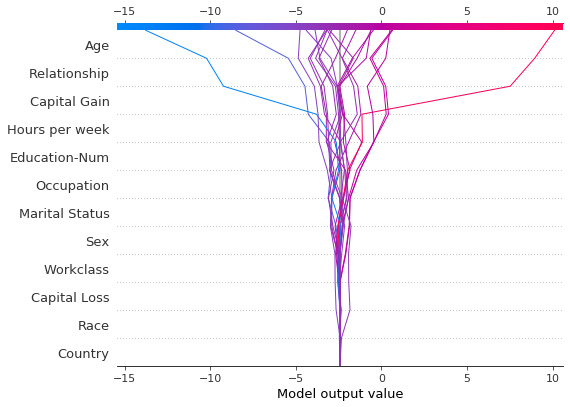

In [3]:
shap.decision_plot(explainer.expected_value, shap_values, features_display, matplotlib=True)

Like the force plot, the decision plot supports `link='logit'` to transform log odds to probabilities.

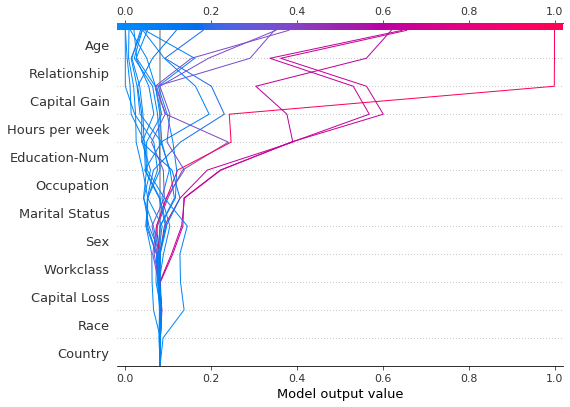

In [4]:
shap.decision_plot(explainer.expected_value, shap_values, features_display, link='logit', matplotlib=True)

Observations can be highlighted using a dotted line style. Here, we highlight a misclassified observation.

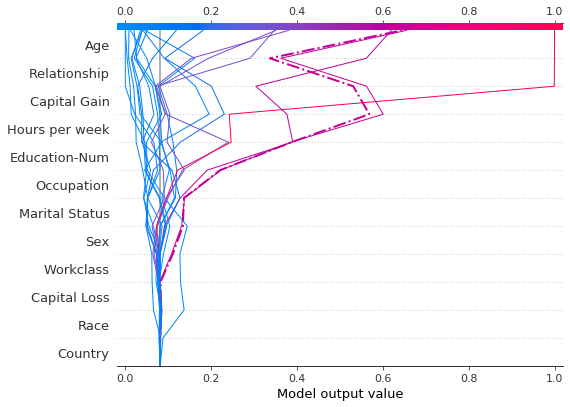

In [5]:
# Our naive cutoff point is zero log odds (probability 0.5).
y_pred = (shap_values.sum(1) + explainer.expected_value) > 0
misclassified = y_pred != y_test[select]
shap.decision_plot(explainer.expected_value, shap_values, features_display, link='logit',
                   highlight=misclassified, matplotlib=True)

Let's inspect the misclassified observation by plotting it alone. When a single observation is plotted, its corresponding feature values are displayed. Notice that the shape of the line has changed. Why? The feature order has changed on the y-axis based on the feature importance for this lone observation. (The section "Preserving order and scale between plots" shows how to use the same feature order for multiple plots.)

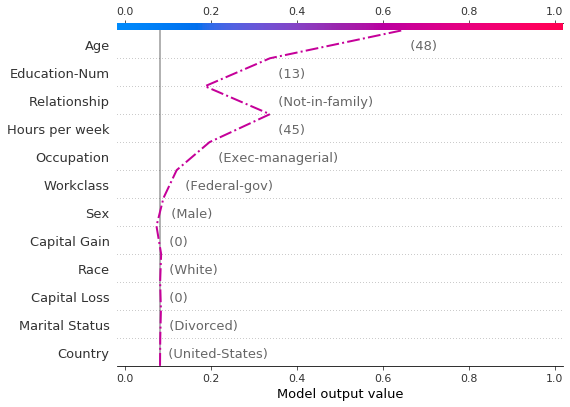

In [6]:
shap.decision_plot(explainer.expected_value, shap_values[misclassified], features_display[misclassified],
                   link='logit', highlight=slice(None), matplotlib=True)

A force plot for the misclassified observation is shown below. In this case, the decision plot and the force plot are both effective at showing how the model arrived at its decision.

In [7]:
shap.force_plot(explainer.expected_value, shap_values[misclassified], features_display[misclassified], link='logit')

# When is a decision plot helpful?
There are several use cases for a decision plot. We present three such cases here.

## (1) Show a large number of feature effects clearly
Like a force plot, a decision plot shows the important features involved in a model's output. However, a decision plot can be more helpful than a force plot when there are a large number of significant features involved. To demonstrate this, we use a model trained on the [Communities and Crime Unnormalized Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized). It has 101 features. The two plots below describe the same prediction. The force plot's horizontal format prevents it from showing all of the significant features clearly. In contrast, the decision plot's vertical format can display the effects of any number of features.

In [8]:
# Load the prediction from disk to keep the example short.
with open('./data/crime.pickle', 'rb') as fl:
    a, b, c = pickle.load(fl)
shap.force_plot(a, b, c)

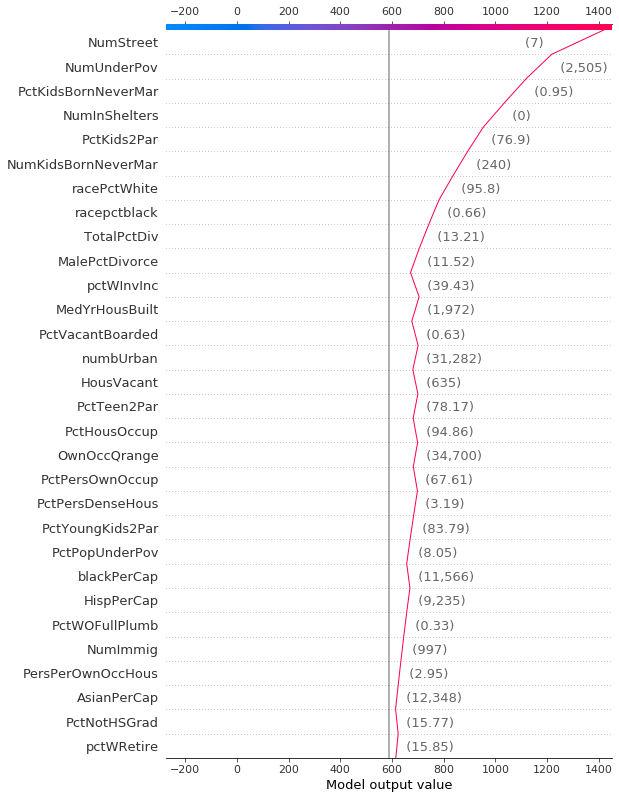

In [9]:
shap.decision_plot(a, b, c, feature_display_range=slice(None, -31, -1), matplotlib=True)

# (2) Identify prediction paths
A decision plot can expose a model's typical prediction paths. In this example we return to the [UCI Adult Income](https://archive.ics.uci.edu/ml/datasets/adult) data. We plot all of the predictions in the probability range [0.98, 1.0] to see what high-scoring predictions have in common. We use `'hclust'` feature ordering to group similar prediction paths. The plot shows two distinct prediction paths: one is dominated by 'Capital Gain' while the other is dominated by 'Capital Loss'.

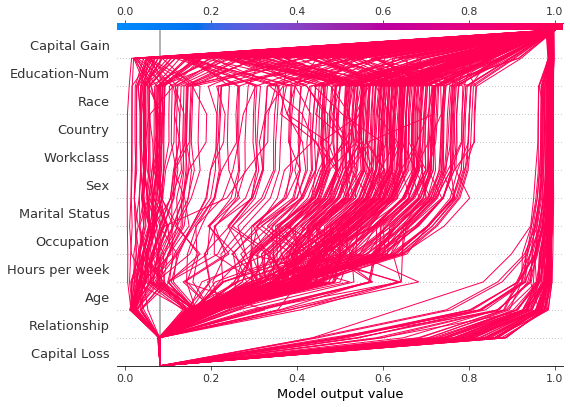

In [10]:
y_pred = model.predict(X_test)  # Get predictions on the probability scale.
T = X_test[y_pred >= 0.98]
shap.decision_plot(explainer.expected_value, explainer.shap_values(T), T, feature_order='hclust', 
                   link='logit', matplotlib=True)

# (3) Identify outliers
Decision plots can help identify outliers. The plot below shows all predictions in the probability range [0.03, 0.1]. Two observations stand out. The effects of 'Age', 'Capital Loss', and 'Capital Gain' define the outliers.

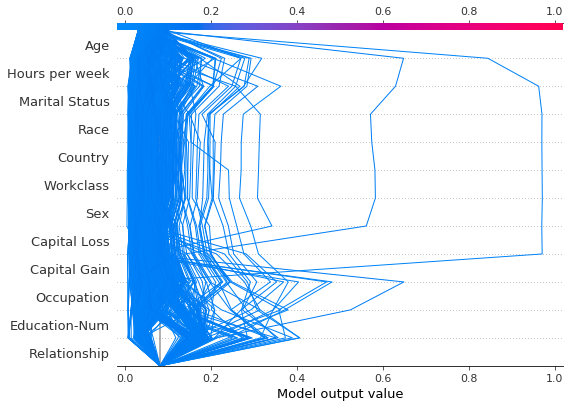

In [11]:
T = X_test[(y_pred >= 0.03) & (y_pred <= 0.1)]
shap.decision_plot(explainer.expected_value, explainer.shap_values(T), T, feature_order='hclust', 
                   link='logit', matplotlib=True)

# SHAP interaction values
The decision plot supports SHAP interaction values as shown below. Notice that the lines do not completely converge to `explainer.expected_value` at the bottom of the plot. This is because there are N(N + 1)/2 = 12(13)/2 = 78 features including interaction and main effects. The decision plot shows only the 20 most important features by default. See the section "Selecting features to display" to learn how to change the default.

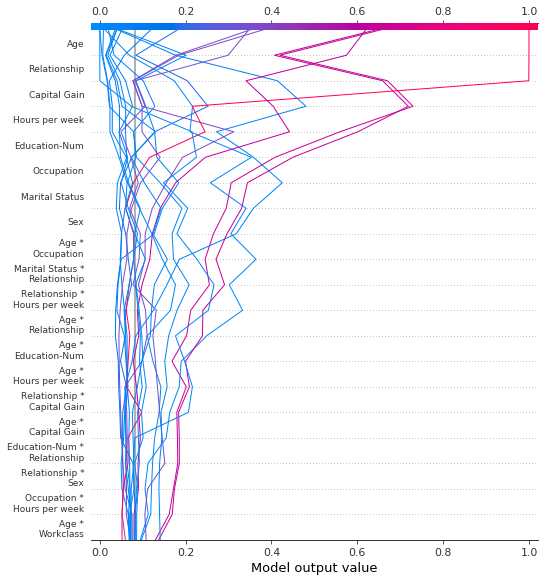

In [12]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, features, link='logit', matplotlib=True)

The decision plot transforms the three-dimensional SHAP interaction structure to a standard two-dimensional SHAP matrix and it generates corresponding feature labels. These structures can be retrieved from a decision plot by setting `return_objects=True`. In this example, we omit the plot by setting `show=False`.

In [13]:
r = shap.decision_plot(explainer.expected_value, shap_interaction_values, features, link='logit', 
                   show=False, matplotlib=True, return_objects=True)
plt.close()
print("SHAP dimensions: {}".format(r.shap_values.shape), "\n")
pprint(r.feature_names[:-11:-1])

SHAP dimensions: (20, 78) 

['Age',
 'Relationship',
 'Capital Gain',
 'Hours per week',
 'Education-Num',
 'Occupation',
 'Marital Status',
 'Sex',
 'Age *\nOccupation',
 'Marital Status *\nRelationship']


# Preserving order and scale between plots

It is often helpful to create several decision plots using the same feature order and x-axis to facilitate direct comparisons. When `return_objects=True`, the decision plot returns plotting structures that can be used in subsequent plots.

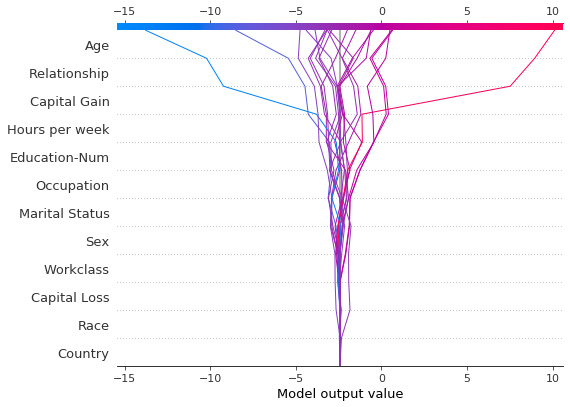

In [24]:
# Create the first plot, returning the plot structures.
r = shap.decision_plot(explainer.expected_value, shap_values, features_display,
                   matplotlib=True, return_objects=True)

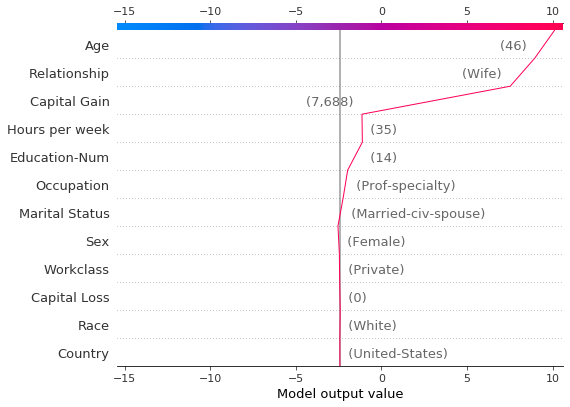

In [15]:
# Create another plot using the same feature order and x-axis extents.
idx = 9
shap.decision_plot(explainer.expected_value, shap_values[idx], features_display.iloc[idx],
                   feature_order=r.feature_idx, xlim=r.xlim,
                   matplotlib=True, show=False)

# Selecting features for display
The features displayed in a decision plot are controlled by two parameters: `feature_order` and `feature_display_range`. The `feature_order` parameter determines how the features are ordered before display. The `feature_display_range` parameter determines which features are actually displayed. It takes either a `slice` or a `range` object as an argument. The `feature_display_range` parameter also controls whether the features are plotted in ascending or descending order.

For example, if `feature_order='importance'` (the default) the decision plot arranges the features in *ascending* order by importance before display. If `feature_display_range=slice(-1, -21, -1)` (the default), the plot shows the last (i.e., the most important) 20 features in descending order. The object `slice(-1, -21, -1)` is interpreted as "start at the last feature and iterate to the 21st feature from the end by a step of -1." The end point, -21, is not included.

The `feature_display_range` parameter is particularly important when `'hclust'` ordering is applied. In this case, many of the important features are positioned at the beginning of the feature range. However, the decision plot shows the end of the feature range by default.

The following plot shows the first 10 out of 78 SHAP interaction features using `'hclust'` ordering. **Note:** Because we show only the first 10 features, the observations do not strike the x-axis at their final predicted values. The snippet `feature_display_range=range(10, -1, -1)` indicates that we start at feature 10 and count to feature -1 by -1. The end point is not included in the range. Hence, we see the features 10 to 0.

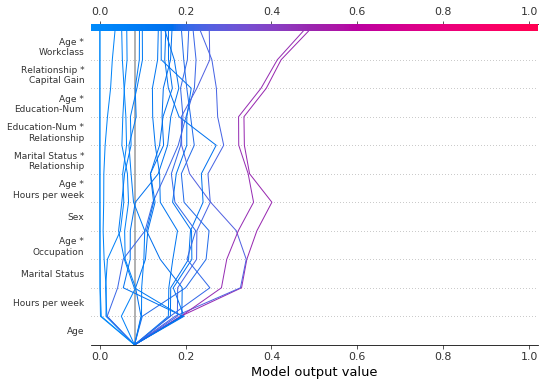

In [16]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, link='logit', feature_order='hclust', 
                   feature_display_range=range(10, -1, -1),
                   matplotlib=True)

We can produce the same plot in ascending order by specifying an ascending range: `range(0, 11, 1)`.

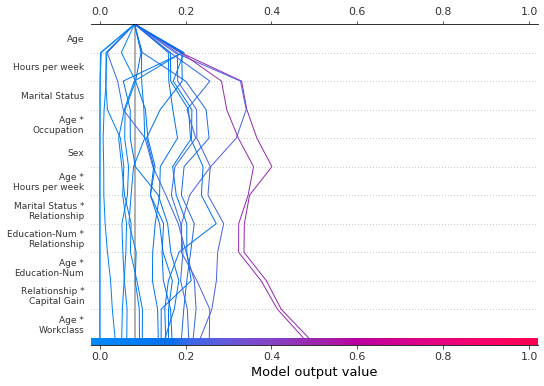

In [17]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, link='logit', feature_order='hclust', 
                   feature_display_range=range(0, 11, 1),
                   matplotlib=True)

When selecting the last features in a range, it is more convenient to use a slice because slices support negative indices. For example, the index -20 indicates the 20th item from the end. The following plot shows the last 10 features in descending `'hclust'` order.

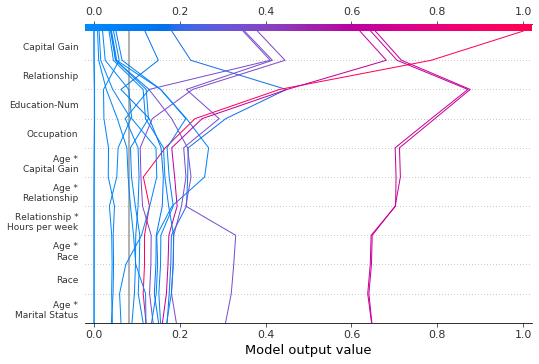

In [18]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, link='logit', feature_order='hclust', 
                   feature_display_range=slice(None, -11, -1),
                   matplotlib=True)

We can display all available features in a number of ways. The simplest is `feature_display_range=slice(None, None, -1)`. **Note:** If your dataset contains many features, this will produce a very large plot.

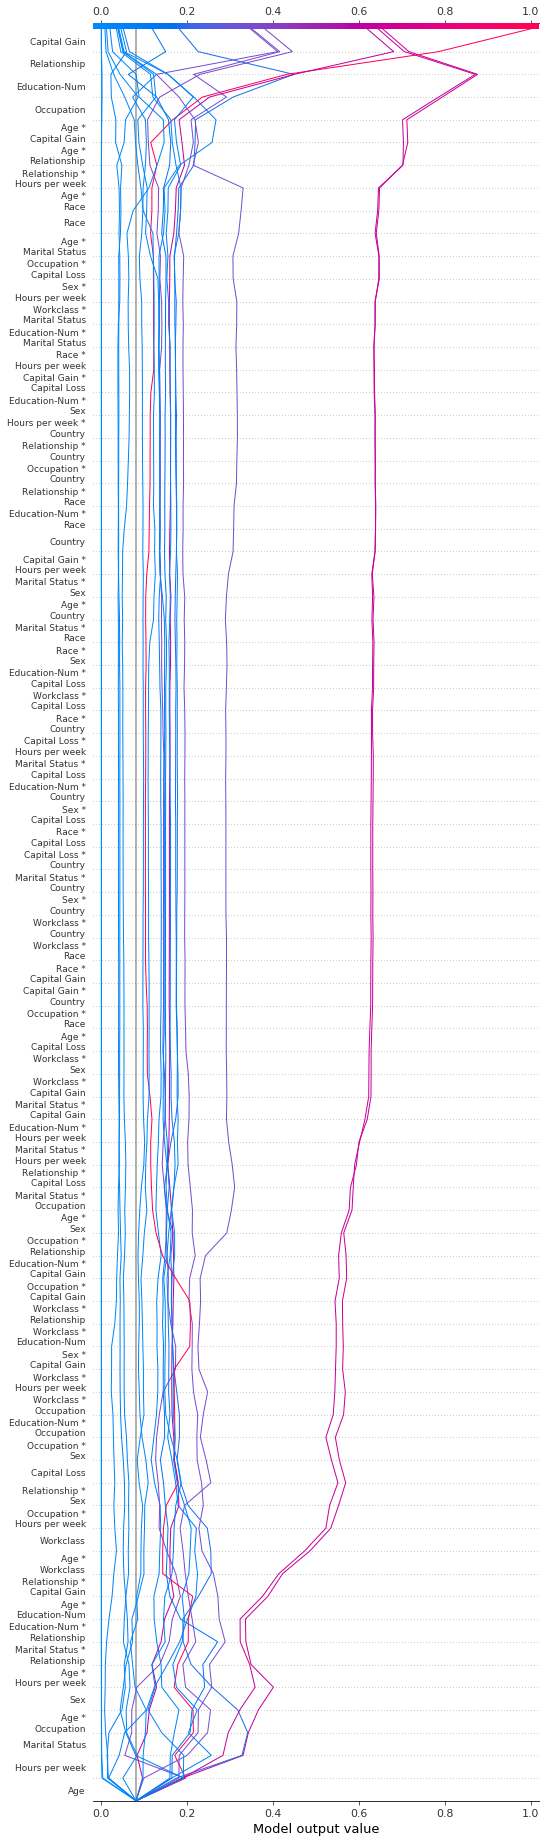

In [19]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, link='logit', feature_order='hclust', 
                   feature_display_range=slice(None, None, -1),
                   matplotlib=True)

# Changing the plot's base value
SHAP values are relative to `explainer.expected_value`: the mean of the raw model predictions for the training data.

In [20]:
# The model's training mean
print(model.predict(X_train, raw_score=True).mean().round(4))

# The explainer expected value
print(explainer.expected_value.round(4))

-2.4297
-2.4297


To obtain correct prediction values, `explainer.expected_value` is added to the sum of SHAP values for each observation.

In [21]:
# The model's raw prediction for the first observation.
print(model.predict(features.iloc[[0]].values, raw_score=True)[0].round(4))

# The corresponding sum of the mean + shap values
print((shap_values[0].sum() + explainer.expected_value).round(4))

-3.1866
-3.1866


Hence, `explainer.expected_value` must be provided to the decision plot to produce correct predictions. Visually, `explainer.expected_value` is the starting value for each prediction. This is not always intuitive. Consider a logistic classification problem. If we choose probability 0.4 as our cutoff value, it might make more sense to the viewer to see the predictions converge at the cutoff point.

The following code shows how to shift the base value for the decision plot to an arbitrary value.

In [25]:
# Choose our new base value in raw model units (log-odds in our case).
p = 0.4  # Probability 0.4
base_value = np.log(p / (1 - p))  # the logit function

# Calculate the shift and apply it to the SHAP values.
shift = explainer.expected_value - base_value
shap_values_shifted = shap_values + shift / shap_values.shape[1]

# Show that the shifted predictions are the same as the original SHAP values.
pred_shap = (explainer.expected_value + shap_values.sum(1)).round(6)
pred_shifted = (base_value + shap_values_shifted.sum(1)).round(6)
print(all(pred_shap == pred_shifted))

True


Use the new base value with the shifted SHAP values...

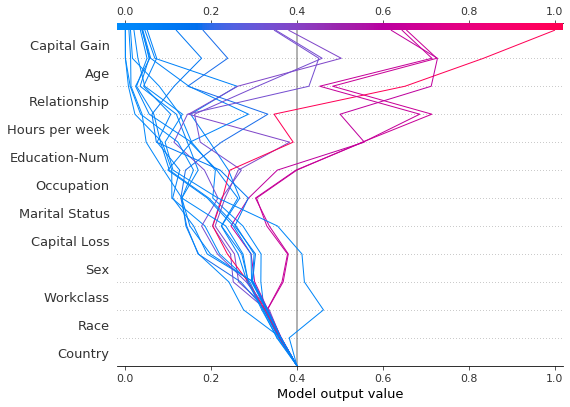

In [23]:
shap.decision_plot(base_value, shap_values_shifted, features_display, link='logit', matplotlib=True)